# XGBoost model of lung cancer risk factors and diagnosis

In this notebook, I'll be examining the relationship and creating a predictive model targetting lung cancer diagnosis. 
We'll do this by modeling features that are/may be associated with the disease. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Read data file

In [2]:
data = pd.read_csv('survey lung cancer.csv')
data.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


 # Define features and target

In [3]:
features = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN']
X = data[features]
y = data['LUNG_CANCER']


In [4]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['GENDER', 'LUNG_CANCER']


# Encode categorical variables

Categorical variables can't be used in the model and will need to be encoded to numerical values. We will use a simple mapping function to encode gender and the label encoder to encode the target.

In [5]:
X['MALE'] = X['GENDER'].map({'M':1, 'F':0})
X_final = X.drop(columns='GENDER')
X_final.head()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,MALE
0,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,63,2,2,2,1,1,1,1,1,2,1,1,2,2,1
4,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


In [6]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE = LE.fit(y)
encoded_y = LE.transform(y)
y_final = pd.DataFrame(encoded_y)
y_final.head()

,0
0,1
1,1
2,0
3,0
4,0


# Fit XGBOOST model

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_final, y_final)
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=24, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluate

In [8]:
from sklearn.metrics import mean_absolute_error

predictions = model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 0.12388609473903973


# Discussion

That's a pretty good result for just a default XGBoost model with no tweaking, which I believe to be the result of bias in the data.
The data in the features will reflect the status of diagnosis, of course people with lung cancer will have a disease phenotype, and people without will not, which the model can easily detect. 

A better database would have the features assessed for everyone at one time point, and then follow up years later with the diagnosis of lung cancer or not. This data would better serve to create a predictive model of lung cancer risk within a set time period. 

Alas, let's take a look at the relationship between features with and without lung cancer diagnosis

In [9]:
from sklearn.feature_selection import mutual_info_regression

X_MI = X_final.copy()
y_MI = y_final.copy()

# Label encoding for categoricals
for colname in X_MI.select_dtypes("object"):
    X_MI[colname], _ = X_MI[colname].factorize()


discrete_features = X_MI.dtypes == int

In [10]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_MI, y_MI.values.ravel(), discrete_features)
mi_scores  

SWALLOWING DIFFICULTY    0.112128
YELLOW_FINGERS           0.065890
ALCOHOL CONSUMING        0.061803
WHEEZING                 0.042014
ALLERGY                  0.034698
SMOKING                  0.034354
ANXIETY                  0.030580
COUGHING                 0.022629
MALE                     0.019144
AGE                      0.008753
PEER_PRESSURE            0.004113
CHRONIC DISEASE          0.000000
FATIGUE                  0.000000
SHORTNESS OF BREATH      0.000000
CHEST PAIN               0.000000
Name: MI Scores, dtype: float64

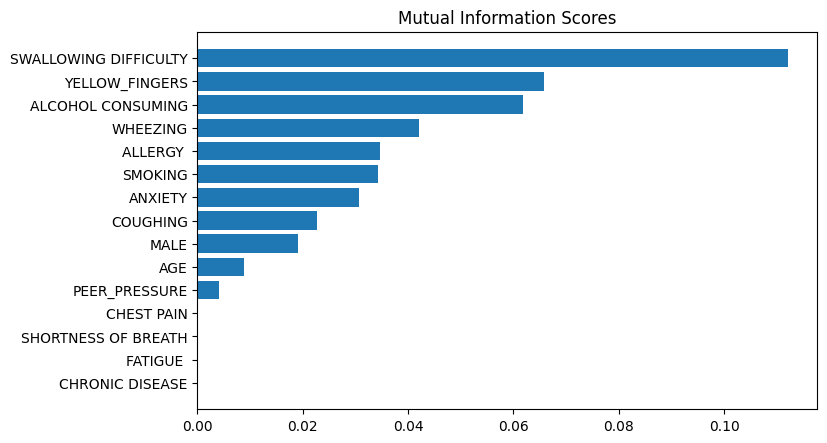

In [11]:
import matplotlib.pyplot as plt

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Mutual Information scores measure the relationship or co-occurence a feature has to one another. The higher the score, the more one outcome affects the other.

# Visualization


Let's use matplotlib and seaborn to do some visualizations of our data.

First, we'll do some data cleaning and then take a look at the distribution of data amongst different features to see if it's balanced.

Below I am just cleaning up the master data frame to encode Lung Cancer status as a binary classification of yes=1 and no=0, as well as a similar strategy for gender, male=1 and female=0. This way, we can add up totals for analysis. Please note that for all other categories, yes=2 and no=1. we will have to keep this in mind when adding totals.

In [12]:
data['LUNG_CANCER'] = data['LUNG_CANCER'].map({'YES':1, 'NO':0})
data['MALE'] = data['GENDER'].map({'M':1, 'F':0})
data = data.drop(columns='GENDER')
data.head()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER,MALE
0,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1,1
1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1,1
2,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0,0
3,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0,1
4,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0,0


Now, lets take a look at the balance between male and female entries in the table. Ideally, we would want to have a balanced distribution.

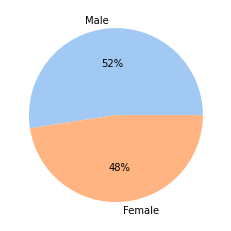

In [13]:
import seaborn as sns

total_male = data["MALE"].sum()
percent_male = total_male/len(data.index)
total_female = len(data.index)-total_male
percent_female = total_female/len(data.index)

#define data for pie chart
gender_percent = [percent_male,percent_female]
labels = ['Male', 'Female']

#define color palette
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(gender_percent, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

Good, it looks like our data represents both Male and Female genders fairly evenly. Let's do the same but for Lung Cancer diagnosis.

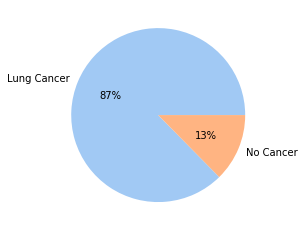

In [14]:
total_cancer = data["LUNG_CANCER"].sum()
percent_cancer = total_cancer/len(data.index)
total_nocancer = len(data.index)-total_cancer
percent_nocancer = total_nocancer/len(data.index)

#define data for pie chart
cancer_percent = [percent_cancer,percent_nocancer]
labels = ['Lung Cancer', 'No Cancer']

#define color palette
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(cancer_percent, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

Unfortunately our data looks like it's heavily skewed towards patients with a Lung Cancer diagnosis. This may have created some bias with our machine learning model, having it trained on unbalanced data may push it towards estimating a lung cancer diagnosis rather than not.

Next, we'll take a look at the distribution of age amongst groups with and without Lung Cancer diagnosis.

First, I'll divide the dataframe into two groups, one group that has a positive lung cancer diagnosis, and a second group that has a negative lung cancer diagnosis. Then, I'll plot the distribution of age for each group overlayed on top of each other to have a look into the difference in age distribution between the two groups.

Patients with Lung Cancer mean age 62.95185185185185
Patients without Lung Cancer mean age 60.743589743589745


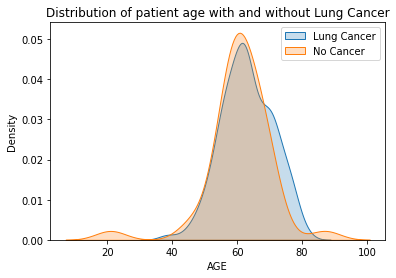

In [15]:
data_cancer = data[data['LUNG_CANCER']==1]
data_no_cancer = data[data['LUNG_CANCER']==0]

sns.kdeplot(data=data_cancer['AGE'], shade=True, label='Lung Cancer')
sns.kdeplot(data=data_no_cancer['AGE'], shade=True, label ='No Cancer')
plt.legend()
plt.title('Distribution of patient age with and without Lung Cancer')

print("Patients with Lung Cancer mean age", data_cancer['AGE'].mean())
print('Patients without Lung Cancer mean age', data_no_cancer['AGE'].mean())

It looks like patients with lung cancer are slightly skewed to be older based off assumptions made looking at the graph and comparing the means between the two groups.

Patients without Lung Cancer mean age 60.743589743589745
Patients with Lung Cancer mean age 62.95185185185185


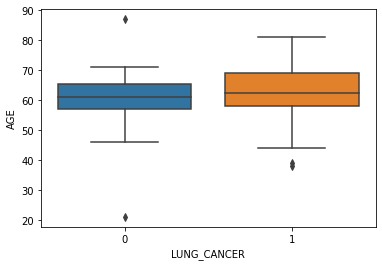

In [16]:
sns.boxplot(data=data, x='LUNG_CANCER', y="AGE", order = [0, 1])
print('Patients without Lung Cancer mean age', data_no_cancer['AGE'].mean())
print("Patients with Lung Cancer mean age", data_cancer['AGE'].mean())

<AxesSubplot:xlabel='LUNG_CANCER', ylabel='AGE'>

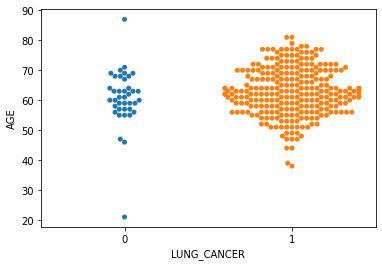

In [17]:
sns.swarmplot(data=data, x='LUNG_CANCER', y="AGE", order = [0, 1])

A boxplot and a swarmplot of the distribution of age between negative and positive lung cancer diagnosis support the same sentiment, that in our data, patients that are diagnosed with Lung Cancer are on average older than those that are not diagnosed. Whether this is difference is statistically different or not, further analysis is required with a standard T-test.